The purpose of this notebook is to create a nice looking heatmap for figure 3.

In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(ggExtra)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
#Load in the cosmic cancer gene census genes
setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
cosmic.genes = read.table("cosmic_genes.csv", sep = ",", header = T)

cosmic.tier1 = cosmic.genes %>% 
filter(Tier %in% "1") %>%
pull(Gene.Symbol)

length(cosmic.tier1)

[1] 579

In [4]:
#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

head(sample.annotation)
dim(sample.annotation)

#get a vector of all African samples
gnomad.african.samples = sample.annotation %>% 
filter(ancestry %in% "afr") %>%
pull(sample)

head(gnomad.african.samples)

,sample,ancestry
,<chr>,<chr>
1,CHMI_CHMI3_WGS2,nfe
2,HG00096,nfe
3,HG00097,nfe
4,HG00099,nfe
5,HG00100,nfe
6,HG00101,nfe


[1] 4151    2

[1] "HG01108" "HG01241" "HG01242" "HG01243" "HG01879" "HG01881"

In [6]:
#Calculate the number of samples with an assigned ancestry group
sample.annotation$ancestry %>% unique()

sample.annotation %>%
filter(ancestry != "NA") %>%
nrow()

[1] "nfe" NA    "fin" "oth" "eas" "amr" "afr" "sas" "mid"

[1] 4120

In [7]:
#Calculate the number of samples for each ancestry group
sample.annotation %>%
group_by(ancestry) %>%
summarise(n())

ancestry,n()
<chr>,<int>
afr,996
amr,547
eas,808
fin,92
mid,128
nfe,682
oth,79
sas,788
NA,31


In [8]:
92+682

[1] 774

In [9]:
#Load in the avana SNP/guide matrix
setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
avana.matrix = read.table("final_avana.txt", sep = "\t", header = T)

head(avana.matrix)

,seq,chr,posL,posR,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAATCCCCCTGAAGGTACCG,chr22,46626903,46626925,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AACAAGAAGGAGATTCAGAA,chr22,16991998,16992020,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AACACCGGTGAGGTATATCG,chr22,24557741,24557763,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AACCAGCAGCGCAAAAACGG,chr22,31345490,31345512,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AACCCGGACGAGGACCCGCG,chr22,31291036,31291058,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,AACGGCATATGCGGCCACGA,chr22,30532670,30532692,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [10]:
#Load in the guide-to-gene mapping file
setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
guide.to.gene = read.table("internal-21q4_v9-achilles-guide-map.csv", sep = ",", header = T) %>%
mutate(gene = word(gene, 1)) %>%
select(sgrna, gene) %>%
rename("seq" = sgrna)

head(guide.to.gene)

,seq,gene
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,SHOC2
2,AAAAAACCCGTAGATAGCCT,NDUFA12
3,AAAAAAGAAGAAAAAACCAG,SDAD1
4,AAAAAAGCTCAAGAAGGAGG,FAM98A
5,AAAAAAGGCTGTAAAAGCGT,ZNF253
6,AAAAAAGGGCTCCAAAAAGG,H2BC7


In [11]:
#Filter the SNP matrix so that it only includes the cosmic tier1 genes
cosmic.tier1.matrix = avana.matrix %>% 
mutate(seq = plyr::mapvalues(from = guide.to.gene$seq, to = guide.to.gene$gene, seq, warn_missing = FALSE)) %>%
select(-chr, -posL, -posR) %>%
filter(seq %in% all_of(cosmic.tier1)) %>%
melt() %>%
group_by(seq, variable) %>%
summarise(sum(value)) %>%
rename("value" = 3) %>%
dcast(formula = seq ~ variable, fill = "value")

#Convert the numbers to numeric
cosmic.tier1.matrix[2:ncol(cosmic.tier1.matrix)] = cosmic.tier1.matrix[2:ncol(cosmic.tier1.matrix)] %>% 
apply(2, as.numeric) %>%
apply(2, function(x) ifelse(x >= 1, 1, 0))
      
      
#Filter cosmic.tier1.matrix so that it only includes African samples
intersecting.samples = intersect(gnomad.african.samples, colnames(cosmic.tier1.matrix))
african.cosmic.tier1.matrix = cosmic.tier1.matrix %>%
select(seq, all_of(intersecting.samples))
      
      
#Calculate the total # affected per sample and per gene, store as two vectors that are ordered from most to least
snps.per.gene = african.cosmic.tier1.matrix %>% 
      select(-seq) %>% 
      apply(1, sum) %>% 
      data.frame() %>% 
      cbind(african.cosmic.tier1.matrix$seq) %>% 
      rename("snps" = 1, "gene" = 2) %>% 
      filter(snps > 98) %>%
      arrange(snps)
      
snps.per.sample = african.cosmic.tier1.matrix %>% 
      select(-seq,) %>% 
      apply(2, sum) %>% 
      sort()
      
head(snps.per.gene)
head(snps.per.sample)

Using seq as id variables

`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.


,snps,gene
,<dbl>,<chr>
1,103,DNMT3A
2,107,MAML2
3,107,WWTR1
4,110,HIP1
5,117,NTRK1
6,120,EP300


HGDP00986   HG03027 HGDP00455   HG02978   HG03476 HGDP00914 
       10        11        11        12        12        12

Using seq as id variables



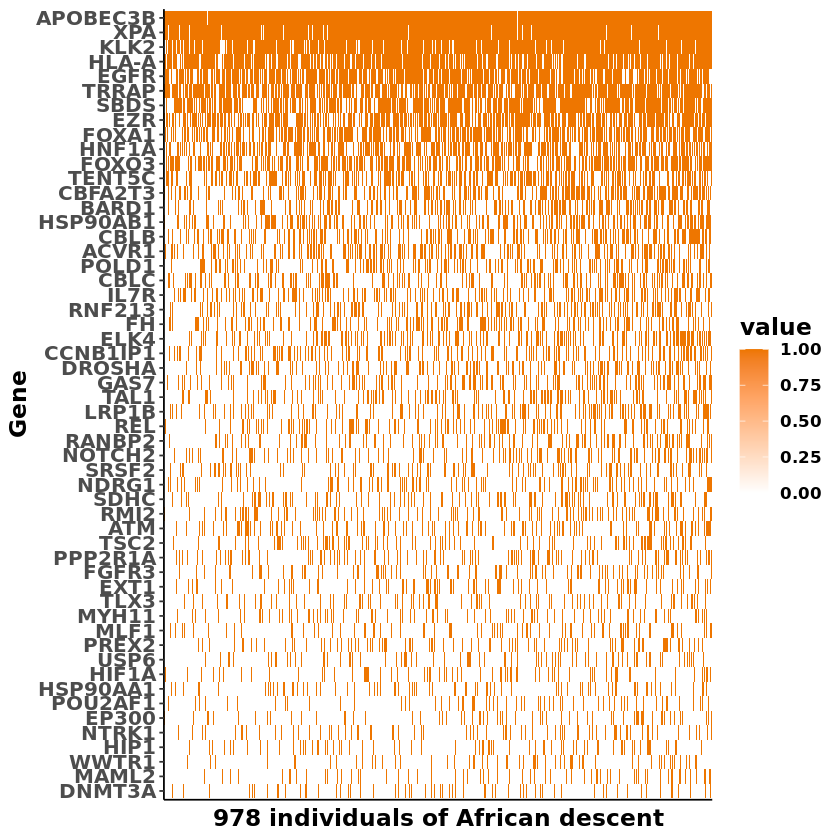

In [94]:
#Plot the plot!
african.cosmic.tier1.matrix %>%
melt() %>%
mutate(variable = factor(variable, levels = names(snps.per.sample))) %>%
mutate(seq = factor(seq, levels = snps.per.gene$gene)) %>%
filter(seq != "NA") %>%
ggplot(aes(x = variable, y = seq, fill = value)) + 
geom_tile() +

scale_fill_gradient2(low = "white", high = "darkorange2", 
limit = c(0, 1)) +

theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(axis.text.x = element_blank(),
     axis.ticks.x = element_blank()) +

ylab("Gene") +
xlab("978 individuals of African descent")

setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
ggsave("affected_cosmic_genes_heatmap.pdf", width = 5, height = 10)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/cosmic_heatmap
gsutil cp affected_cosmic_genes_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Using seq as id variables



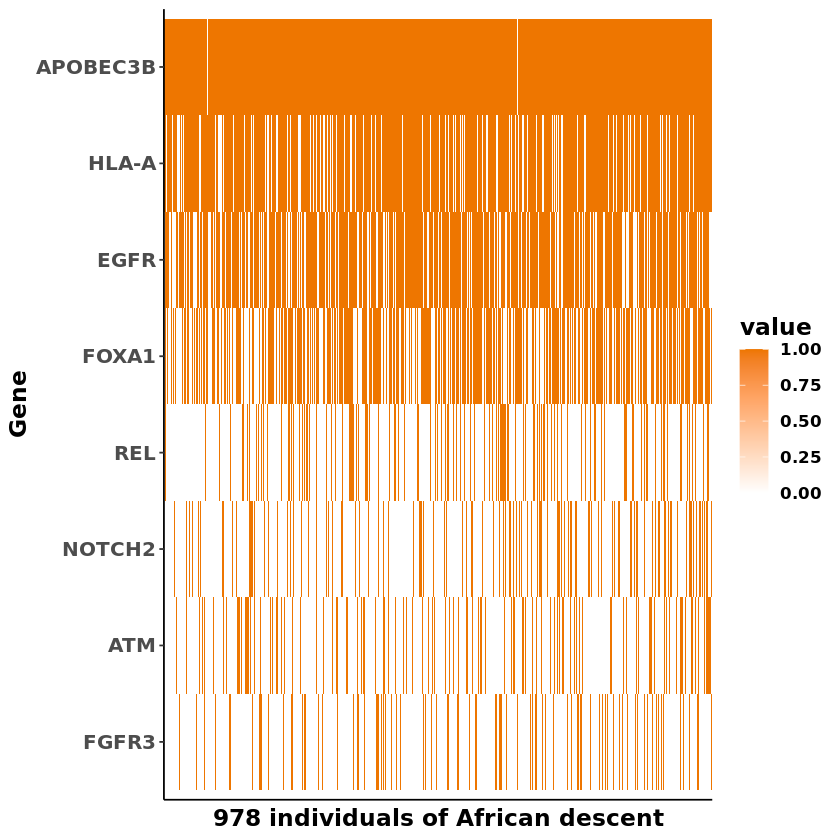

In [14]:
#Create a version of this figure with only a few genes
genes.to.keep = c("APOBEC3B", "HLA-A", "EGFR", "FOXA1", "REL", "NOTCH2", "ATM", "FGFR3")

african.cosmic.tier1.matrix %>%
melt() %>%
mutate(variable = factor(variable, levels = names(snps.per.sample))) %>%
mutate(seq = factor(seq, levels = snps.per.gene$gene)) %>%
filter(seq != "NA") %>%
filter(seq %in% all_of(genes.to.keep)) %>%
ggplot(aes(x = variable, y = seq, fill = value)) + 
geom_tile() +

scale_fill_gradient2(low = "white", high = "darkorange2", 
limit = c(0, 1)) +

theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(axis.text.x = element_blank(),
     axis.ticks.x = element_blank()) +

ylab("Gene") +
xlab("978 individuals of African descent")

setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
ggsave("few_genes_affected_cosmic_genes_heatmap.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/cosmic_heatmap
gsutil cp few_genes_affected_cosmic_genes_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Create the propaganda version of the figure

In [16]:
#Create a vector that has a subset of the cosmic Tier1 genes
#This only includes genes flagged as being oncogenes or tumor suppressors
cosmic.tier1.nofusion = cosmic.genes %>% 
filter(Role.in.Cancer %in% c("oncogene", "TSG")) %>%
filter(Tier %in% "1") %>%
pull(Gene.Symbol)

In [17]:
#First calculate which genes are most differentially affected across ancestry groups
fraction.affected.matrix = avana.matrix %>% 
mutate(seq = plyr::mapvalues(from = guide.to.gene$seq, to = guide.to.gene$gene, seq, warn_missing = FALSE)) %>%
select(-chr, -posL, -posR) %>%
filter(seq %in% all_of(cosmic.tier1.nofusion)) %>%
melt() %>%
group_by(seq, variable) %>%
summarise(sum(value)) %>%
rename("value" = 3) %>%
dcast(formula = seq ~ variable, fill = "value")

#Convert the numbers to numeric
fraction.affected.matrix[2:ncol(fraction.affected.matrix)] = fraction.affected.matrix[2:ncol(fraction.affected.matrix)] %>% 
apply(2, as.numeric) %>%
apply(2, function(x) ifelse(x >= 1, 1, 0))
      
head(fraction.affected.matrix)

Using seq as id variables

`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.


,seq,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,HGDP01053,HGDP00191,HGDP01399,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACVR1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,ACVR1B,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ACVR2A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AKT1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AKT2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,APC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [120]:
###For each gene calculate the fraction affected for each ancestry group.
affected.ancestry.matrix = fraction.affected.matrix %>%
melt() %>%
mutate("ancestry" = variable) %>%
mutate(ancestry = plyr::mapvalues(ancestry, from = sample.annotation$sample, to = sample.annotation$ancestry, warn_missing = FALSE)) %>%
filter(ancestry %in% all_of(unique(sample.annotation$ancestry))) %>%
filter(ancestry != "NA") %>%
mutate(ancestry = gsub("nfe", "EUR", ancestry)) %>%
mutate(ancestry = gsub("amr", "AMR", ancestry)) %>%
mutate(ancestry = gsub("sas", "SAS", ancestry)) %>%
filter(ancestry != "oth") %>%
mutate(ancestry = gsub("eas", "EAS", ancestry)) %>%
mutate(ancestry = gsub("afr", "AFR", ancestry)) %>%
mutate(ancestry = gsub("mid", "MID", ancestry)) %>%
mutate(ancestry = gsub("fin", "EUR", ancestry))

#Calculate the number of samples in each ancestry group
samples.per.ancestry = affected.ancestry.matrix %>%
select(variable, ancestry) %>%
distinct(variable, ancestry, .keep_all = TRUE) %>%
group_by(ancestry) %>%
summarise(n()) %>%
rename("number" = 2)

#Now group by ancestry and gene, and calculate the fraction affected
affected.per.gene.per.ancestry = affected.ancestry.matrix %>%
group_by(seq, ancestry) %>%
summarise(sum(value)) %>%
rename("count" = 3) %>%
mutate("total_num" = ancestry) %>%
mutate(total_num = plyr::mapvalues(total_num, from = samples.per.ancestry$ancestry, to = samples.per.ancestry$number, warn_missing = FALSE)) %>%
mutate(total_num = as.numeric(total_num)) %>%
mutate("fraction_affected" = count/total_num)
head(affected.per.gene.per.ancestry)


#Now calculate the maximum differential for all of the genes 
maximum.differential = affected.per.gene.per.ancestry %>%
group_by(seq) %>%
summarise(max(fraction_affected) - min(fraction_affected)) %>%
rename("max_differential" = 2) %>%
arrange(desc(max_differential))
head(maximum.differential)


#Get a list of propaganda genes
propaganda.genes = maximum.differential %>%
head(n = 20) %>%
pull(seq)

#Get an order for all of the propaganda genes based upon their frequency in AFR
propaganda.gene.order = affected.per.gene.per.ancestry %>%
filter(seq %in% propaganda.genes) %>%
filter(ancestry %in% "AFR") %>%
arrange(desc(fraction_affected)) %>%
pull(seq)


head(propaganda.gene.order)

Using seq as id variables

`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.


seq,ancestry,count,total_num,fraction_affected
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ACVR1,AFR,323,978,0.3302658
ACVR1,AMR,510,537,0.9497207
ACVR1,EAS,768,773,0.9935317
ACVR1,EUR,718,758,0.9472296
ACVR1,MID,114,120,0.9500000
ACVR1,SAS,741,771,0.9610895


seq,max_differential
<chr>,<dbl>
TRRAP,0.7366143
ACVR1,0.6632658
PREX2,0.6421030
XPC,0.3925838
FOXA1,0.3593984
TENT5C,0.3554622


[1] "XPA"   "EGFR"  "TRRAP" "SBDS"  "FOXA1" "HNF1A"

In [92]:
#Filter the SNP matrix so that it only includes the propaganda genes
cosmic.propaganda.matrix = avana.matrix %>% 
mutate(seq = plyr::mapvalues(from = guide.to.gene$seq, to = guide.to.gene$gene, seq, warn_missing = FALSE)) %>%
select(-chr, -posL, -posR) %>%
filter(seq %in% all_of(propaganda.genes)) %>%
melt() %>%
group_by(seq, variable) %>%
summarise(sum(value)) %>%
rename("value" = 3) %>%
dcast(formula = seq ~ variable, fill = "value")

head(cosmic.propaganda.matrix)


#Convert the numbers to numeric
cosmic.propaganda.matrix[2:ncol(cosmic.propaganda.matrix)] = cosmic.propaganda.matrix[2:ncol(cosmic.propaganda.matrix)] %>% 
apply(2, as.numeric) %>%
apply(2, function(x) ifelse(x >= 1, 1, 0))

Using seq as id variables

`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.


,seq,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,HGDP01053,HGDP00191,HGDP01399,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACVR1,1,1,1,1,1,1,1,2,1,⋯,1,1,1,1,1,1,1,1,1,1
2,BARD1,1,0,1,1,0,0,0,1,0,⋯,1,0,0,1,1,1,1,1,0,0
3,CBLB,2,2,2,0,2,0,2,0,2,⋯,0,0,0,0,0,0,2,0,2,0
4,DROSHA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,EGFR,1,0,1,1,1,1,1,1,0,⋯,1,1,0,0,1,1,1,0,1,0
6,FAT1,0,1,1,0,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0


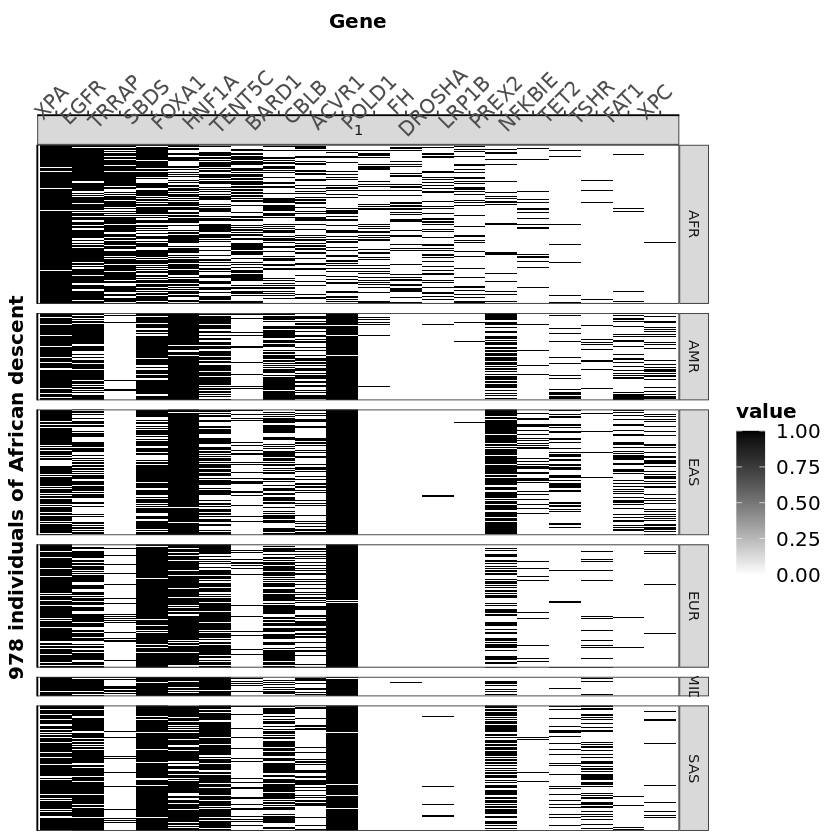

In [133]:
#Plot the plot 

cosmic.propaganda.matrix %>%
melt(id = "seq") %>%
filter(seq != "NA") %>%
mutate("ancestry" = variable) %>%
mutate(ancestry = plyr::mapvalues(ancestry, from = sample.annotation$sample, to = sample.annotation$ancestry, warn_missing = FALSE)) %>%
filter(ancestry %in% all_of(unique(sample.annotation$ancestry))) %>%
filter(ancestry != "NA") %>%
mutate(ancestry = gsub("nfe", "EUR", ancestry)) %>%
mutate(ancestry = gsub("amr", "AMR", ancestry)) %>%
mutate(ancestry = gsub("sas", "SAS", ancestry)) %>%
filter(ancestry != "oth") %>%
mutate(ancestry = gsub("eas", "EAS", ancestry)) %>%
mutate(ancestry = gsub("afr", "AFR", ancestry)) %>%
mutate(ancestry = gsub("mid", "MID", ancestry)) %>%
mutate(ancestry = gsub("fin", "EUR", ancestry)) %>%
mutate(value = as.numeric(value)) %>%
mutate(seq = factor(seq, levels = propaganda.gene.order)) %>%
ggplot(aes(x = seq, y = variable, fill = value)) + 
geom_tile() +
facet_grid(ancestry ~ 1, scales = "free_y", space = "free_y") +

scale_fill_gradient2(low = "white", high = "black", limit = c(0, 1)) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text = element_text(size = 10, angle = 45),
axis.title = element_text(size = 12,face = "bold")
) +

theme(
legend.title = element_text(size = 12, face = "bold"),
legend.text = element_text(size = 12)
) +

theme(axis.text.y = element_blank(),
     axis.ticks.y = element_blank()) +

xlab("Gene") +
ylab("978 individuals of African descent") +

scale_x_discrete(position = "top") 

setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
ggsave("propaganda_affected_cosmic_genes_heatmap.pdf", width = 5, height = 10)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/cosmic_heatmap
gsutil cp propaganda_affected_cosmic_genes_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))